# 🐝 Projet ML/IA - 'To bee or not to bee'

Ce notebook sert de base pour l'extraction de caractéristiques, la visualisation, et l'entraînement de modèles sur des images d'insectes (abeilles, bourdons, etc.).

In [1]:
# 1. Imports & Configuration
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.measure import regionprops, label
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='whitegrid')


C:\Users\edoua\AppData\Local\Temp\ipykernel_12192\3381562676.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# 2. Charger les chemins vers les images, masques et labels
image_dir = 'train/'
mask_dir = 'train/masks/'
label_df = pd.read_excel('classif.xlsx')  # Modifier selon le nom réel du fichier
label_df.head()


,ID,bug type,species
0,1,Bee,Apis mellifera
1,2,Bee,Apis mellifera
2,3,Bee,Apis mellifera
3,4,Bee,Apis mellifera
4,5,Bee,Apis mellifera


In [3]:
# 3. Fonction d'extraction de caractéristiques
def extract_features(image_path, mask_path):
    image = imread(image_path)
    mask = imread(mask_path, as_gray=True) > 0
    props = regionprops(label(mask.astype(int)))
    
    features = {}
    features['area_ratio'] = np.sum(mask) / (mask.shape[0] * mask.shape[1])
    
    for i, color in enumerate(['R', 'G', 'B']):
        channel = image[:, :, i]
        values = channel[mask]
        features[f'{color}_mean'] = np.mean(values)
        features[f'{color}_std'] = np.std(values)
        features[f'{color}_min'] = np.min(values)
        features[f'{color}_max'] = np.max(values)
        features[f'{color}_median'] = np.median(values)
    
    # Caractéristiques de forme
    if props:
        features['eccentricity'] = props[0].eccentricity
        features['extent'] = props[0].extent
    else:
        features['eccentricity'] = 0
        features['extent'] = 0
    
    return features


In [ ]:
# Appliquer l'extraction à toutes les images 
feature_list = []

for i, row in label_df.iterrows():
    img_path = os.path.join(image_dir, f"{row['ID']}.JPG")
    mask_path = os.path.join(mask_dir, f"binary_{row['ID']}.tif")
    
    # Filtrer les ID avec des données incomplètes
    try:
        if not os.path.exists(img_path):
            print(f"[WARNING] Image manquante : {img_path}")
            continue
        if not os.path.exists(mask_path):
            print(f"[WARNING] Masque manquant : {mask_path}")
            continue
        
        feats = extract_features(img_path, mask_path)
        feats['bug type'] = row['bug type']
        feature_list.append(feats)
    except Exception as e:
        print(f"[ERREUR] Problème avec ID {row['ID']}: {e}")

df_features = pd.DataFrame(feature_list)
df_features.head()


[WARNING] Masque manquant : train/masks/binary_154.tif


,area_ratio,R_mean,R_std,R_min,R_max,R_median,G_mean,G_std,G_min,G_max,G_median,B_mean,B_std,B_min,B_max,B_median,eccentricity,extent,bug type
0,0.007428,68.085745,47.955399,5,208,56.0,54.882747,45.311197,3,199,37.0,39.891969,36.250747,0,193,24.0,0.392483,0.506544,Bee
1,0.008553,63.786498,42.153508,2,248,55.0,52.079650,42.866124,2,251,34.0,35.735147,34.617117,0,244,19.0,0.595418,0.431831,Bee
2,0.022093,107.176333,58.771359,3,255,114.0,87.794710,60.057604,0,255,86.0,63.383043,54.823596,0,255,52.0,0.240478,0.448143,Bee
3,0.013187,87.588243,46.322587,5,219,88.0,71.031852,46.085760,3,213,61.0,50.432535,37.445621,0,201,36.0,0.735380,0.427390,Bee
4,0.009165,123.177003,62.355944,6,255,134.0,100.897964,63.029355,0,250,91.0,80.946170,60.624962,0,245,63.0,0.650617,0.396221,Bee


Variance expliquée par les 2 premières composantes : [0.79210602 0.11026583]


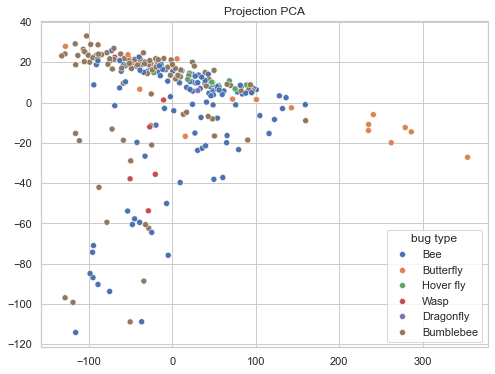

In [18]:
# Visualisation PCA
X = df_features.drop(columns=['bug type'])
y = df_features['bug type']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
variance = pca.explained_variance_ratio_[:2]
print(f"Variance expliquée par les 2 premières composantes : {variance}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("Projection PCA")
plt.show()


In [21]:
# Modèle SVM simple
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[19 11  0  0  0]
 [ 4 11  0  0  0]
 [ 1  0  1  0  0]
 [ 2  0  0  0  0]
 [ 1  0  0  0  0]]
              precision    recall  f1-score   support

         Bee       0.70      0.63      0.67        30
   Bumblebee       0.50      0.73      0.59        15
   Butterfly       1.00      0.50      0.67         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.62        50
   macro avg       0.44      0.37      0.39        50
weighted avg       0.61      0.62      0.61        50



C:\Users\edoua\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edoua\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edoua\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [ ]:
# Convertion des masques en format TIFF correct
from PIL import Image
import glob

for jpeg_path in glob.glob(os.path.join(mask_dir, "*.tif")):
    try:
        img = Image.open(jpeg_path)
        img = img.convert("L")  
        img.save(jpeg_path, format="TIFF")  
    except Exception as e:
        print(f"Erreur avec {jpeg_path}: {e}")
